### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

## <font color="white">0. Library Setup</font>

- Install and Activate the Conda Pack: automlx251_p311_cpu_x86_64_v2

- Basic setup for the Notebook. We will be running some magic commands to display matplotlib plots and to automatically reload modules



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules such as 
- gzip: compress/decompress files
- pandas: Accessing data
- numpy: Preprocessing data
- seaborn: Visualization
- matplotlib: Visualization
- sklearn: Mathematical Operations and other ML tasks

In [56]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score,confusion_matrix,make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [57]:
# Add settings for the Plots
plt.rcParams['figure.figsize']=[10,7]
plt.rcParams['font.size']= 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")

Import and Initialize the AutoML Library

In [76]:
import automlx
from automlx import init

## <font color="white">1. Loading the Adult Census Income Dataset </font>

Fetch the adult datase from OpenML

In [59]:
dataset=fetch_openml(name='adult',as_frame=True)
df,y =dataset.data,dataset.target

Get an overview of the data

In [60]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


A quick look at the data shows that it contains a mix of both Numerical and Text Data

## <font color="white">1.1 Data Exploration</font>

### <font color="white">1.1.1 We also need to check for the data types of the columns</font>

In [61]:
pd.DataFrame({'Data type': df.dtypes}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
Data type,category,category,float64,category,float64,category,category,category,category,category,category,category,category,category


### <font color="white">1.1.2 Checking for Missing Values</font>

In [62]:
pd.DataFrame({'% missing values': df.isnull().sum()*100 /len(df)}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
% missing values,0.0,5.730724,0.0,0.0,0.0,0.0,5.751198,0.0,0.0,0.0,0.0,0.0,0.0,1.754637


### <font color="white">1.1.3 Visualizing the distribution of the target variable - Income</font>

[Text(0, 0, '37155'), Text(0, 0, '11687')]

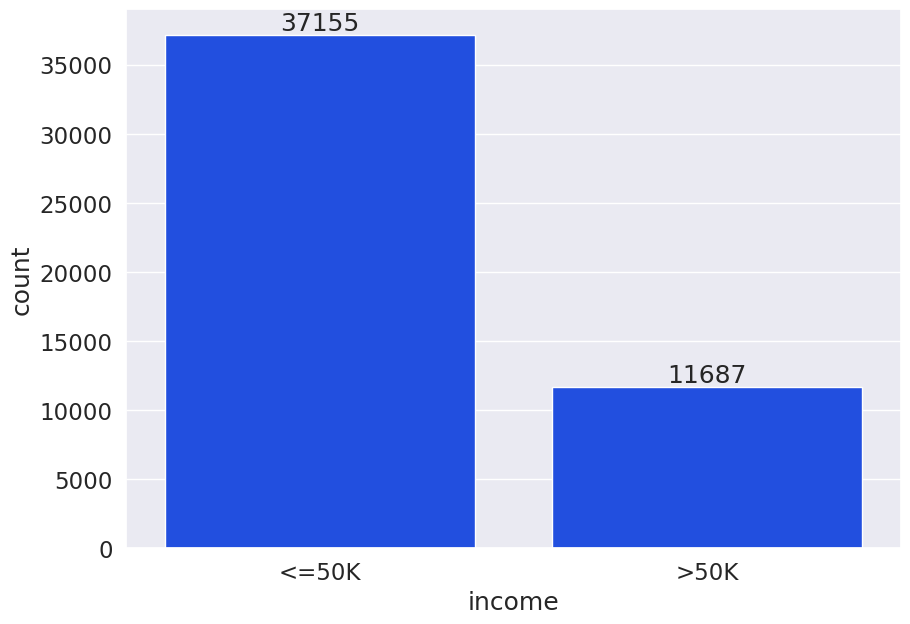

In [63]:
y_df=pd.DataFrame(y)
y_df.columns=['income']


ax=sns.countplot(x='income',data=y_df)
ax.bar_label(ax.containers[0])

## <font color="white">1.2 Data Preprocessing</font>

### <font color="white">1.2.1 Fixing the data types</font>

In [64]:
numeric_columns=['age','capitalgain','capitalloss','hoursperweek']

for col in df.columns:
    if col in numeric_columns:
        df[col]=df[col].astype(int)

### <font color="white">1.2.2 Split the data into a train, test, validation with target field converted to a binary classification field</font>

In [65]:
X_train,X_test,y_train,y_test=train_test_split(df,y.map({'>50K':1,'<=50K':0}).astype(int),train_size=0.7,random_state=0)

### <font color="white">1.2.3 Inspect the Training set</font>

In [66]:
X_train.shape,X_test.shape

((34189, 14), (14653, 14))

## <font color="white">2. Apply AutoML </font>

### <font color="white">2.0 Set the Engine </font>

In [13]:
init(engine='local')

### <font color="white">2.1 Create an Instance of AutoMLX </font>

AutoMLX instance automatically finds a tuned model based on a prediction task and a given dataset. It contains the following modules
#### <font color='white'>1. <font color="pink">Preprocessing: </font>Data Cleaning, Data Imputation, Feature Engineering and Normalization </font> 
#### <font color='white'>2. <font color="pink">Algorithm Selection: </font>Identify the right classifiaction algorithm from the following: </font> 

- AdaBoostClassifier
- DecisionTreeClassifier
- ExtraTreesClassifier
- TorchMLPClassifier
- KNeighborsClassifier
- LGBMClassifier
- LinearSVC
- LogisticRegression
- RandomForestClassifier
- SVC
- XGBClassifier
- GaussianNB

#### <font color='white'>3. <font color="pink">Adaptive Sampling: </font>Selects a subset of the data for the model to be trained on and updates the sampling method based on the performance of the models</font> 
#### <font color='white'>4. <font color="pink">Feature Selection: </font>Select a subset of the data features based on the previously selected model </font> 
#### <font color='white'>5. <font color="pink">Hyperparameter Tuning: </font>Finds the right model parameters to maximize score for the given dataset </font> 

All these modules are in the AutoML pipeline to automate the Machine Learning process with minimal user Input / Interaction


### <font color="white">2.2 Train the Model Using AutoML </font>

Initialize the automl pipeline, define the type of task and then fit the training data into the pipeline

In [ ]:
est1=automlx.Pipeline(task='classification')
est1.fit(X_train,y_train)

[2025-10-27 05:25:15,703] [automlx.interface] Dataset shape: (16752,14)
[2025-10-27 05:25:15,814] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-27 05:25:16,288] [automlx.data_transform] Preprocessing completed. Took 0.474 secs
[2025-10-27 05:25:16,303] [automlx.process] Running Model Generation
[2025-10-27 05:25:16,361] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-27 05:25:16,362] [automlx.process] SVC is disabled. The SVC model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-27 05:25:16,365] [automlx.process] Model Generation completed.
[2025-10-27 05:25:16,437] [automlx.model_selection] Running Model Selection


A model est1 is now automatically generated. Using the model we can do the following:
- Call its predict_proba method: Predicts the probability estimates for each class on the testing set X_test
- We use the roc_auc_score metric to evaluate the performance of the prediction on the testing set X_test

In [17]:
y_proba=est1.predict_proba(X_test)
score_default=roc_auc_score(y_test,y_proba[:,1])

In [18]:
print(f'Score on test data : {score_default}')

Score on test data : 0.9140858492615117


Explain the model

In [ ]:
explainer=automlx.MLExplainer(est1,X_train,y_train,task="classification")

In [ ]:
explanation=explainer.explain_model()
explanation.to_dataframe()

### <font color="white">2.3 AutoML Optimization Process </font>


During the AutoMl process the following information is logged
- Information about the training data
- Information about the AutoML Pipeline such as 
    - Most relevant features selected
    - Best choice Algorithm
    - Selected hyper parameters


In [19]:
est1.print_summary()

""
"(34189, 14)"
None
"KFoldSplit(Shuffle=True, Seed=7, folds=5, stratify by=target)"
neg_log_loss
XGBClassifier
"{'learning_rate': 0.10242113515453982, 'min_child_weight': 2, 'max_depth': 4, 'reg_alpha': 0.0007113117640155693, 'booster': 'gbtree', 'reg_lambda': 1.001, 'n_estimators': 141, 'use_label_encoder': False}"
25.1.1
"3.11.11 | packaged by conda-forge | (main, Mar 3 2025, 20:43:55) [GCC 13.3.0]"


Step,# Samples,# Features,Algorithm,Hyperparameters,Score (neg_log_loss),All Metrics,Runtime (Seconds),Memory Usage (GB),Finished
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",-0.3813,{'neg_log_loss': -0.38129734602336923},1.9454,0.2919,Sun Oct 26 05:46:19 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,CatBoostClassifier,"{'iterations': 235, 'learning_rate': 0.787168, 'leaf_estimation_method': 'Newton', 'colsample_bylevel': 0.096865, 'depth': 3, 'l2_leaf_reg': 2.567326, 'feature_border_type': 'UniformAndQuantiles', 'model_size_reg': 3.85132, 'leaf_estimation_iterations': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'auto_class_weights': 'SqrtBalanced', 'allow_writing_files': False, 'allow_const_label': True}",-0.3881,{'neg_log_loss': -0.38808832474759775},3.9578,0.3219,Sun Oct 26 05:44:26 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}",-0.3898,{'neg_log_loss': -0.3898051926295403},15.8840,0.2817,Sun Oct 26 05:44:44 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LogisticRegressionClassifier,"{'C': 1.0, 'solver': 'liblinear', 'class_weight': 'balanced'}",-0.3908,{'neg_log_loss': -0.3907935186356912},0.4531,0.2602,Sun Oct 26 05:46:20 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,RandomForestClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced'}",-0.4093,{'neg_log_loss': -0.40930045927988684},6.7410,0.2708,Sun Oct 26 05:44:51 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,ExtraTreesClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced', 'criterion': 'gini'}",-0.4196,{'neg_log_loss': -0.4196315514455088},4.6622,0.2714,Sun Oct 26 05:44:32 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,TorchMLPClassifier,"{'optimizer_class': 'Adam', 'shuffle_dataset_each_epoch': True, 'optimizer_params': {}, 'criterion_class': None, 'criterion_params': {}, 'scheduler_class': None, 'scheduler_params': {}, 'batch_size': 128, 'lr': 0.001, 'epochs': 18, 'input_transform': 'auto', 'tensorboard_dir': None, 'use_tqdm': None, 'prediction_batch_size': 128, 'prediction_input_transform': 'auto', 'shuffling_buffer_size': None, 'depth': 4, 'num_logits': 1000, 'div_factor': 2, 'activation': 'ReLU', 'dropout': 0.1}",-0.8208,{'neg_log_loss': -0.820796843596572},89.4686,0.6650,Sun Oct 26 05:46:17 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,GaussianNB,{},-1.0622,{'neg_log_loss': -1.0622002049203993},0.4447,0.2593,Sun Oct 26 05:44:33 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,DecisionTreeClassifier,"{'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 1.0, 'class_weight': None}",-4.6323,{'neg_log_loss': -4.632288461805368},0.6227,0.2661,Sun Oct 26 05:44:27 2025
Adaptive Sampling,"{1: 6730, 2: 6730, 3: 6730, 4: 6730, 5: 6730}",15,AdaptiveSamplingStage_XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",-0.3782,{'neg_log_loss': -0.37817011702109865},3.3871,0.2985,Sun Oct 26 05:46:29 2025


#### <font color="white">2.3.1 Algorithm Selection </font>

We can plot and visualize the results of the AutoML Algorithm Selection. Each Algorithm selection trial is a tuple containing
- Algorithm
- Number of Samples
- Number of Features
- Mean Cross Validation Score
- Hyperparameters
- All Cross Validation scores
- Total Cross Validation Times
- Memory Usage in GB

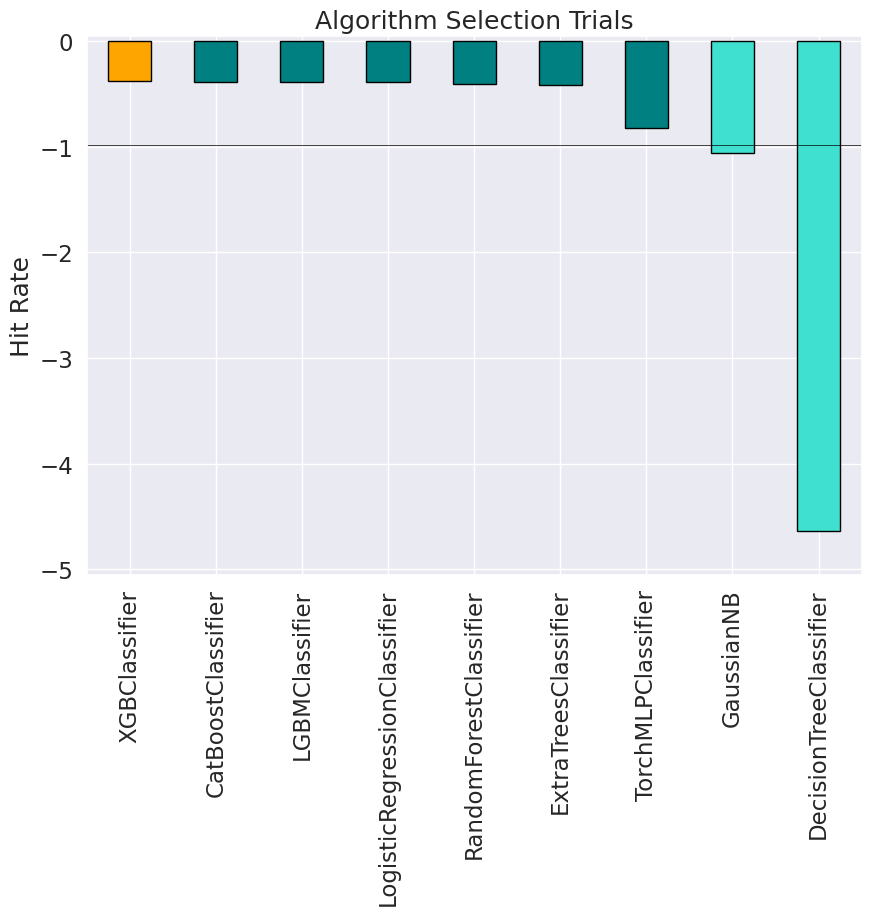

In [33]:
trials = est1.completed_trials_summary_[
        est1.completed_trials_summary_["Step"].str.contains("Model Selection")
    ]


name_of_score_column = f"Score ({est1._inferred_score_metric[0].name})"
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
scores = trials[name_of_score_column].tolist()
models = trials["Algorithm"].tolist()

y_margin=0.10*(max(scores)-min(scores))
s=pd.Series(scores,index=models).sort_values(ascending=False)

colors = []
for f in s.keys():
    if f.strip() == est1.selected_model_.strip():
        colors.append("orange")
    elif s[f] >= s.mean():
        colors.append("teal")
    else:
        colors.append("turquoise")


fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel("Hit Rate")
s.plot.bar(ax=ax, color=colors, edgecolor="black")
ax.axhline(y=s.mean(), color="black", linewidth=0.5)
plt.show()

#### <font color="white">2.3.2 Adaptive Sampling </font>

In [36]:
trials = est1.completed_trials_summary_[
        est1.completed_trials_summary_["Step"].str.contains("Adaptive Sampling")
    ]

trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)

scores=[x[3] for x in trials]
n_samples=[x[1] for x in trials]

y_margin=0.10*(max(scores)-min(scores))


fig,ax=plt.subplots(1)
ax.set_title('Adaptive Sampling({})'.format(trials[0][0]))
ax.set_xlabel('Dataset sample size')
ax.set_ylabel(est1._inferred_score_metric[0])
ax.grid(color='g',linestyle='-',linewidth=0.1)
ax.set_ylim(min(scores)-y_margin,max(scores)+y_margin)
ax.plot(n_samples,scores,'k:',markers='s',color='teal',markersize=3)
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

#### <font color="white">2.3.3 Feature Selection </font>

In [48]:
print(f'features selected:{est1.selected_features_names_}')
trials = est1.completed_trials_summary_[
        est1.completed_trials_summary_["Step"].str.contains("Adaptive Sampling")
    ]
est1.completed_trials_summary_

features selected:['age', 'capitalgain', 'capitalloss', 'education', 'education-num', 'fnlwgt', 'hoursperweek', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'sex_1', 'sex_2', 'workclass']


,Step,# Samples,# Features,Algorithm,Hyperparameters,Score (neg_log_loss),All Metrics,Runtime (Seconds),Memory Usage (GB),Finished
0,Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, ...",-0.381297,{'neg_log_loss': -0.38129734602336923},1.945430,0.291916,Sun Oct 26 05:46:19 2025
1,Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,CatBoostClassifier,"{'iterations': 235, 'learning_rate': 0.787168,...",-0.388088,{'neg_log_loss': -0.38808832474759775},3.957793,0.321918,Sun Oct 26 05:44:26 2025
2,Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'l...",-0.389805,{'neg_log_loss': -0.3898051926295403},15.884042,0.281700,Sun Oct 26 05:44:44 2025
3,Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LogisticRegressionClassifier,"{'C': 1.0, 'solver': 'liblinear', 'class_weigh...",-0.390794,{'neg_log_loss': -0.3907935186356912},0.453079,0.260246,Sun Oct 26 05:46:20 2025
4,Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,RandomForestClassifier,"{'n_estimators': 100, 'min_samples_split': 0.0...",-0.4093,{'neg_log_loss': -0.40930045927988684},6.741041,0.270805,Sun Oct 26 05:44:51 2025
...,...,...,...,...,...,...,...,...,...,...
157,Model Tuning,"{1: 12222, 2: 12222, 3: 12222, 4: 12223, 5: 12...",15,XGBClassifier,"{'learning_rate': 0.0001, 'min_child_weight': ...",-0.6912,{'neg_log_loss': -0.6911999162246485},2.095547,0.311302,Sun Oct 26 05:55:50 2025
158,Model Tuning,"{1: 12222, 2: 12222, 3: 12222, 4: 12223, 5: 12...",15,XGBClassifier,"{'learning_rate': 0.0001, 'min_child_weight': ...",-0.6912,{'neg_log_loss': -0.6911999174202923},2.580630,0.311913,Sun Oct 26 05:55:52 2025
159,Model Tuning,"{1: 12222, 2: 12222, 3: 12222, 4: 12223, 5: 12...",15,XGBClassifier,"{'learning_rate': 0.0001, 'min_child_weight': ...",-0.691215,{'neg_log_loss': -0.6912154271501312},2.397571,0.311813,Sun Oct 26 05:55:55 2025
160,Model Tuning,"{1: 12222, 2: 12222, 3: 12222, 4: 12223, 5: 12...",15,XGBClassifier,"{'learning_rate': 0.0001, 'min_child_weight': ...",-0.691215,{'neg_log_loss': -0.691215428004673},2.127307,0.311893,Sun Oct 26 05:55:58 2025


#### <font color="white">2.3.4 Hyperparameter Tuning </font>

In [ ]:
trials = _pipeline.completed_trials_summary_[
        _pipeline.completed_trials_summary_["Step"].str.contains("Model Tuning")
    ]
    name_of_score_column = f"Score ({_pipeline._inferred_score_metric[0].name})"
    trials.replace([np.inf, -np.inf], np.nan, inplace=True)
    trials.dropna(subset=[name_of_score_column], inplace=True)
    trials.drop(trials[trials["Finished"] == -1].index, inplace=True)
    trials["Finished"] = trials["Finished"].apply(
        lambda x: time.mktime(datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y").timetuple())
    )
    trials.sort_values(by=["Finished"], ascending=True, inplace=True)
    scores = trials[name_of_score_column].tolist()
    score = []
    score.append(scores[0])
    for i in range(1, len(scores)):
        if scores[i] >= score[i - 1]:
            score.append(scores[i])
        else:
            score.append(score[i - 1])
    y_margin = 0.10 * (max(score) - min(score))
    fig, ax = plt.subplots(1)
    ax.set_title("Hyperparameter Tuning Trials")
    ax.set_xlabel("Iteration $n$")
    ax.set_ylabel("Hit Rate")
    ax.grid(color="g", linestyle="-", linewidth=0.1)
    ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
    ax.plot(range(1, len(trials) + 1), score, "k:", marker="s", color="teal", markersize=3)
    plt.show()

#### <font color="white">2.3.5 Confusion Matrix </font>

Text(83.25, 0.5, 'Actual')

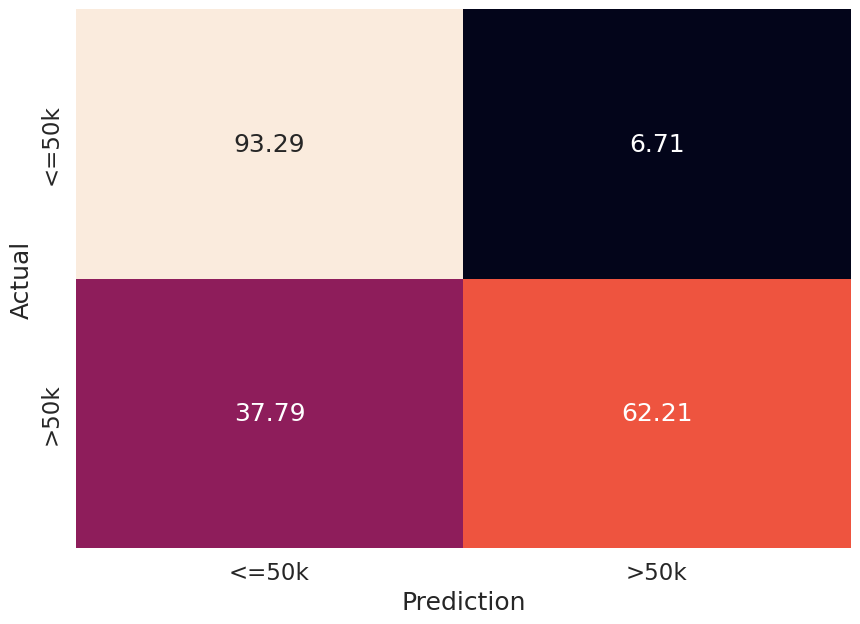

In [53]:
y_pred=est1.predict(X_test)
cm=confusion_matrix(y_test.astype(int),y_pred,labels=[False,True])
cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

df_cm=pd.DataFrame(cm)
df_cm=df_cm*100

ax=sns.heatmap(df_cm,annot=True,fmt='.2f',cbar=False,xticklabels=['<=50k','>50k'],yticklabels=['<=50k','>50k'])

ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

### <font color="white">2.4 Analyze AutoML Optimization Process </font>

#### <font color="white">2.4.1 Provide a Specific Model List to AutoML </font>

AutoMLX allows for specification of a model or a combination of models based on the following algorithms:

- AdaBoostClassifier
- DecisionTreeClassifier
- ExtraTreesClassifier
- TorchMLPClassifier
- KNeighborsClassifier
- LGBMClassifier
- LinearSVC
- LogisticRegression
- RandomForestClassifier
- SVC
- XGBClassifier
- GaussianNB

In [73]:
est2=automlx.Pipeline(model_list='LogisticRegression')
est2.fit(X_train,y_train)
y_proba=est2.predict_proba(X_test)
score_default=roc_auc_score(y_test,y_proba[:,1])
print(f'Score on test data : {score_default}')

[2025-10-26 15:26:45,165] [automlx.interface] Dataset shape: (34189,14)
[2025-10-26 15:26:45,264] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-26 15:26:46,063] [automlx.data_transform] Preprocessing completed. Took 0.799 secs
[2025-10-26 15:26:46,074] [automlx.process] Running Model Generation


AttributeError: 'str' object has no attribute 'remove'

#### <font color="white">2.4.2 Define a Custom Validation Set </font>

In [78]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,train_size=0.7,random_state=0)

est3=automlx.Pipeline()
est3.fit(X_train,y_train,X_val,y_val)


[2025-10-26 15:36:53,070] [automlx.interface] Dataset shape: (23932,14)
[2025-10-26 15:36:53,176] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-26 15:36:53,907] [automlx.data_transform] Preprocessing completed. Took 0.731 secs
[2025-10-26 15:36:53,918] [automlx.process] Running Model Generation
[2025-10-26 15:36:53,976] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-26 15:36:53,976] [automlx.process] SVC is disabled. The SVC model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-26 15:36:53,978] [automlx.process] Model Generation completed.
[2025-10-26 15:36:54,065] [automlx.model_selection] Running Model Selection
[LightGBM] [Info] Number of positive: 2500, number of negative: 2500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012600 seconds.
You

In [ ]:
y_proba=est2.predict_proba(X_test)
score_default=roc_auc_score(y_test,y_proba[:,1])
print(f'Score on test data : {score_default}')

#### <font color="white">2.4.3 Increase the number of tuned models </font>

In [ ]:
est3=automlx.Pipeline(n_algos_tuned=2,model_list=['GausSianNB','LogisticRegression','DecisionTreeClassifier'])
est3.fit(X_train,y_train,X_val,y_val)

In [ ]:
y_proba=est2.predict_proba(X_test)
score_default=roc_auc_score(y_test,y_proba[:,1])
print(f'Score on test data : {score_default}')

#### <font color="white">2.4.3 Specify a Different Scoring Metric to AutoML </font>

The default score metrics for automlx are
- For classification: neg_log_loss
- For Regression: neg_mean_squared_error

The available metrics and charts to choose from are:
- For Binary Classification - Like 1 or 0
    - Metrics
        - roc_auc
        - accuracy
        - Hamming Loss
        - precision and its alternatives (micro,macro,weighted,samples)
        - recall and its alternatives (micro,macro,weighted,samples)
        - f1 and its alternatives (micro,macro,weighted,samples)
    - Charts
        - ROC Curve
        - Precision, Recall Curve
        - Lift Chart
        - Gain Chart
        - Confusion Matrix
- For Multiclass Classification - Discreet Data like Colours
    - Metrics
        - neg_log_loss
        - Hamming Loss
        - roc_auc
        - accuracy
        - precision and its alternatives (micro,macro,weighted,samples)
        - recall and its alternatives (micro,macro,weighted,samples)
        - f1 and its alternatives (micro,macro,weighted,samples)
    - Charts
        - Precision By Label
        - Recall By Label
        - ROC Curve
        - F1 By Label
        - Precision - Recall Curve
        - Confusion Matrix
        - Jaccard By Label
- For Regression - Continuous Data like Prices
    - Metrics
        - R - Squared
        - Explained Variance Score
        - Mean Squared Error
            - neg_mean_squared_error
            - neg_mean_squared_log_error
        - Root Mean Squared Error
        - Mean Absolute Error
            - neg_mean_absolute_error
        - neg_median_absolute_error
        - Mean Residuals
    - Charts
        - A plot of Actual Vs Predicted Values
        - A plot of Residuals Quantile - Quantile: should be close to a straight line
        - A plot of Residuals vs Predicted Values: should not have a good structure
        - A plot of Residuals vs Actual Values: should not have a good structure

In [ ]:
#specifying to automl to optimize the accuracy metric
est3=automlx.Pipeline(score_metric='accuracy',model_list=['GausSianNB','LogisticRegression','DecisionTreeClassifier'])
est3.fit(X_train,y_train,X_val,y_val)

In [ ]:
y_proba=est2.predict_proba(X_test)
score_default=roc_auc_score(y_test,y_proba[:,1])
print(f'Score on test data : {score_default}')

#### <font color="white">2.4.4 Specify a User Defined Scoring Function to AutoML </font>

In [ ]:
#Specifying a user defined score function using scikit learn model_scorer
score_fn=make_scorer(f1_score,greater_is_better=True,needs_proba=False,average=macro)
est3=automlx.Pipeline(score_metric=score_fn,model_list=['GausSianNB','LogisticRegression','DecisionTreeClassifier'])
est3.fit(X_train,y_train,X_val,y_val)

In [ ]:
y_proba=est2.predict_proba(X_test)
score_default=roc_auc_score(y_test,y_proba[:,1])
print(f'Score on test data : {score_default}')

#### <font color="white">2.4.5 Specify a time budget to AutoML </font>

In [ ]:
est3=automlx.Pipeline()
est3.fit(X_train,y_train,X_val,y_val,time_budget=10)

In [ ]:
y_proba=est2.predict_proba(X_test)
score_default=roc_auc_score(y_test,y_proba[:,1])
print(f'Score on test data : {score_default}')

#### <font color="white">2.4.6 Specify a Minimum Set of Features to AutoML </font>

In [ ]:
est3=automlx.Pipeline(min_features=['fnlwgt','native-country'])
est3.fit(X_train,y_train,X_val,y_val,time_budget=10)

In [ ]:
y_proba=est2.predict_proba(X_test)
score_default=roc_auc_score(y_test,y_proba[:,1])
print(f'Score on test data : {score_default}')
print(f'Selected Features : {est3.selected_feature_names_}')

# <font color="white">References </font>

Examples: https://automl.oraclecorp.com

Oracle AutoML: https://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf

Interpretable Machine Learning: https://christophm.github.io/interpretable-ml-book